# Insurance cost prediction using linear regression


## <span id="1"></span> ** Overview **
Columns:
- **age: ** age of primary beneficiary 
- **sex: ** insurance contractor gender, female, male 
- **bmi: ** body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9 
- **children: ** number of children covered by health insurance / number of dependents
- **smoker: ** smoking
- **region: ** the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- **charges: ** individual medical costs billed by health insurance

In [1]:
!conda install numpy pytorch torchvision cpuonly -c pytorch -y
!pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



In [24]:
!pip install pandas
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import seaborn as sns
from collections import Counter

## Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [4]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

103.1%

To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe.

In [6]:
dataframe = pd.read_csv(DATA_FILENAME)
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Let us answer some basic questions about the dataset. 


**How many rows does the dataset have?**

In [7]:
num_rows = dataframe.shape[0]
print(num_rows)

1338


**How many columns doe the dataset have**

In [8]:
num_cols = dataframe.shape[1]
print(num_cols)

7


**What are the column titles of the input variables?**

In [9]:
input_cols = list(dataframe.columns.values)
input_cols

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

**Which of the input columns are non-numeric or categorial variables ?**

In [10]:
dataframe.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [11]:
categorical_cols = [c for c in dataframe.columns if c not in dataframe._get_numeric_data().columns]
categorical_cols

['sex', 'smoker', 'region']

**What are the column titles of output/target variable(s)?**

In [13]:
output_cols = [dataframe.columns[6]]
output_cols

['charges']

**What is the minimum, maximum and average value of the `charges` column?**

In [14]:
max_charges=dataframe['charges'].max()
max_charges

63770.42801

In [15]:
min_charges=dataframe['charges'].min()
min_charges

1121.8739

In [16]:
avg_charges=dataframe['charges'].mean()
avg_charges

13270.422265141257

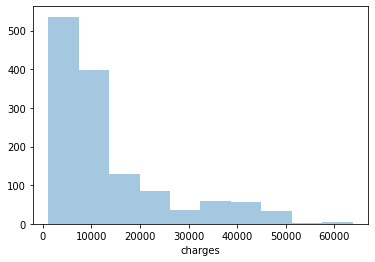

In [17]:
sns.distplot(dataframe['charges'], kde=False, bins=10);

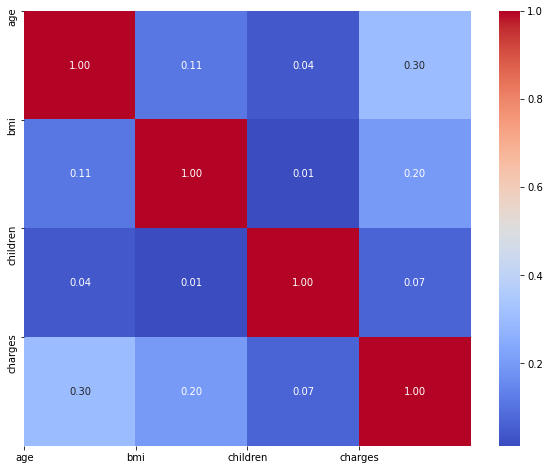

In [18]:
corr = dataframe.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(10, 8))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

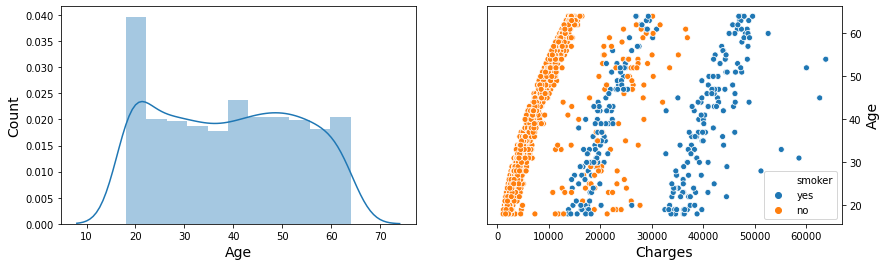

In [20]:
f, axes = plt.subplots(1,2,figsize=(14,4))

sns.distplot(dataframe['age'], ax = axes[0])
axes[0].set_xlabel('Age', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].yaxis.tick_left()

sns.scatterplot(x = 'charges', y = 'age', data = dataframe, hue = 'smoker', ax = axes[1])
axes[1].set_xlabel('Charges', fontsize=14)
axes[1].set_ylabel('Age', fontsize=14)
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()

plt.show()

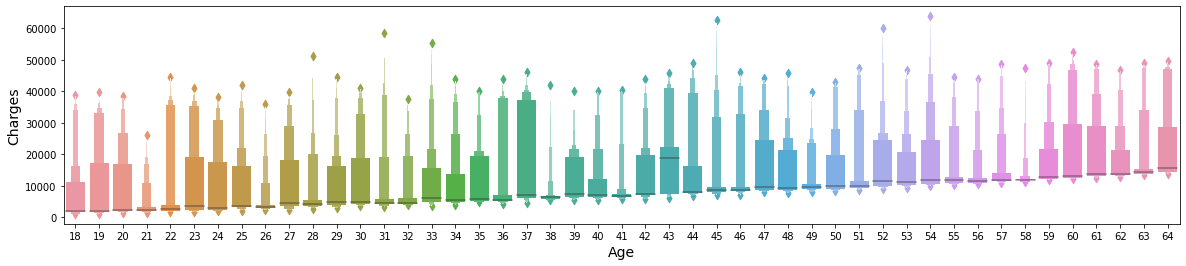

In [21]:
f, axe = plt.subplots(1,1,figsize=(20,4))
sns.boxenplot(x = 'age', y = 'charges', data = dataframe, ax = axe)
axe.set_xlabel('Age', fontsize=14)
axe.set_ylabel('Charges', fontsize=14)
plt.show()

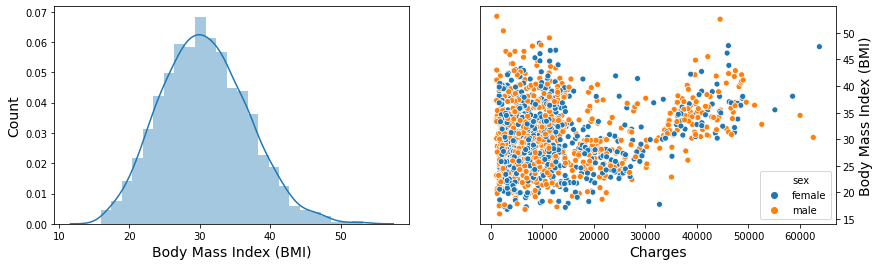

In [22]:
f, axes = plt.subplots(1,2,figsize=(14,4))

sns.distplot(dataframe['bmi'], ax = axes[0])
axes[0].set_xlabel('Body Mass Index (BMI)', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].yaxis.tick_left()

sns.scatterplot(x = 'charges', y = 'bmi', data = dataframe, hue = 'sex',ax = axes[1])
axes[1].set_xlabel('Charges', fontsize=14)
axes[1].set_ylabel('Body Mass Index (BMI)', fontsize=14)
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()

plt.show()

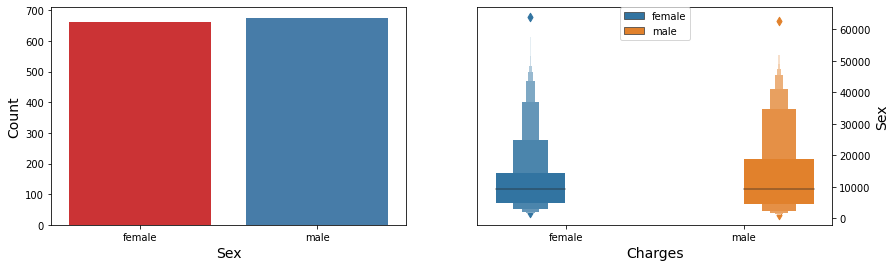

In [26]:
sex_list = Counter(dataframe['sex'])
labels = sex_list.keys()
sizes = sex_list.values()

f, axes = plt.subplots(1,2,figsize=(14,4))

sns.countplot(dataframe['sex'], ax = axes[0], palette="Set1")
axes[0].set_xlabel('Sex', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].yaxis.tick_left()

sns.boxenplot(x = 'sex', y = 'charges', data = dataframe, hue = 'sex', ax = axes[1])
axes[1].set_xlabel('Charges', fontsize=14)
axes[1].set_ylabel('Sex', fontsize=14)
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].legend(bbox_to_anchor=(0.6,1), loc=1, borderaxespad=0.)

plt.show()

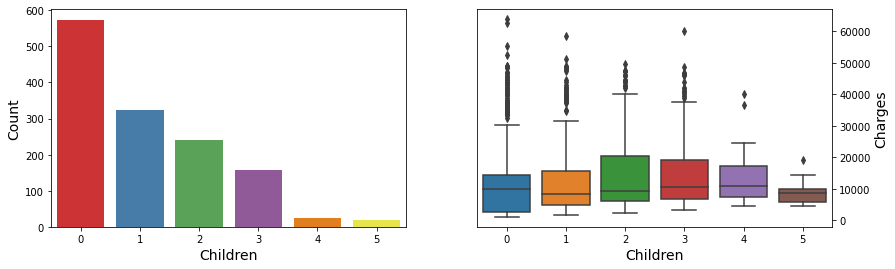

In [27]:
children_list = Counter(dataframe['children'])
labels = children_list.keys()
sizes = children_list.values()

f, axes = plt.subplots(1,2,figsize=(14,4))

sns.countplot(dataframe['children'], ax = axes[0], palette="Set1")
axes[0].set_xlabel('Children', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].yaxis.tick_left()

sns.boxplot(x = 'children', y = 'charges', data = dataframe, ax = axes[1])
axes[1].set_xlabel('Children', fontsize=14)
axes[1].set_ylabel('Charges', fontsize=14)
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()

plt.show()

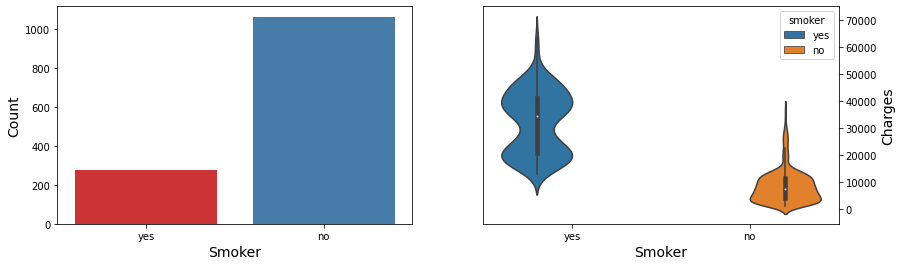

In [28]:
smoker_list = Counter(dataframe['smoker'])
labels = smoker_list.keys()
sizes = smoker_list.values()

f, axes = plt.subplots(1,2,figsize=(14,4))

sns.countplot(dataframe['smoker'], ax = axes[0], palette="Set1")
axes[0].set_xlabel('Smoker', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].yaxis.tick_left()

sns.violinplot(x = 'smoker', y = 'charges', data = dataframe, hue = 'smoker', ax = axes[1])
axes[1].set_xlabel('Smoker', fontsize=14)
axes[1].set_ylabel('Charges', fontsize=14)
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()

plt.show()

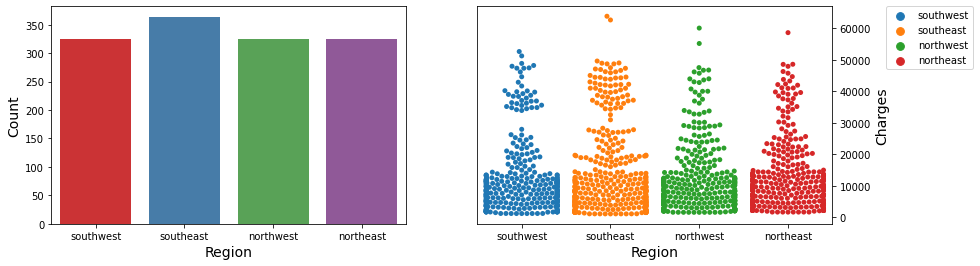

In [29]:
region_list = Counter(dataframe['region'])
labels = region_list.keys()
sizes = region_list.values()

f, axes = plt.subplots(1,2,figsize=(14,4))

sns.countplot(dataframe['region'], ax = axes[0], palette="Set1")
axes[0].set_xlabel('Region', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].yaxis.tick_left()

sns.swarmplot(x = 'region', y = 'charges', data = dataframe, hue = 'region', ax = axes[1])
axes[1].set_xlabel('Region', fontsize=14)
axes[1].set_ylabel('Charges', fontsize=14)
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].legend(bbox_to_anchor=(1.15, 1), loc=2, borderaxespad=0.)

plt.show()

## Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays.

In [30]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

In [31]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[1.90000000e+01, 0.00000000e+00, 2.79000000e+01, ...,
         1.00000000e+00, 3.00000000e+00, 1.68849240e+04],
        [1.80000000e+01, 1.00000000e+00, 3.37700000e+01, ...,
         0.00000000e+00, 2.00000000e+00, 1.72555230e+03],
        [2.80000000e+01, 1.00000000e+00, 3.30000000e+01, ...,
         0.00000000e+00, 2.00000000e+00, 4.44946200e+03],
        ...,
        [1.80000000e+01, 0.00000000e+00, 3.68500000e+01, ...,
         0.00000000e+00, 2.00000000e+00, 1.62983350e+03],
        [2.10000000e+01, 0.00000000e+00, 2.58000000e+01, ...,
         0.00000000e+00, 3.00000000e+00, 2.00794500e+03],
        [6.10000000e+01, 0.00000000e+00, 2.90700000e+01, ...,
         1.00000000e+00, 1.00000000e+00, 2.91413603e+04]]),
 array([[16884.924 ],
        [ 1725.5523],
        [ 4449.462 ],
        ...,
        [ 1629.8335],
        [ 2007.945 ],
        [29141.3603]]))

**Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [32]:
inputs = torch.from_numpy(inputs_array).type(torch.float32)
targets = torch.from_numpy(targets_array).type(torch.float32)
inputs, targets

(tensor([[1.9000e+01, 0.0000e+00, 2.7900e+01,  ..., 1.0000e+00, 3.0000e+00,
          1.6885e+04],
         [1.8000e+01, 1.0000e+00, 3.3770e+01,  ..., 0.0000e+00, 2.0000e+00,
          1.7256e+03],
         [2.8000e+01, 1.0000e+00, 3.3000e+01,  ..., 0.0000e+00, 2.0000e+00,
          4.4495e+03],
         ...,
         [1.8000e+01, 0.0000e+00, 3.6850e+01,  ..., 0.0000e+00, 2.0000e+00,
          1.6298e+03],
         [2.1000e+01, 0.0000e+00, 2.5800e+01,  ..., 0.0000e+00, 3.0000e+00,
          2.0079e+03],
         [6.1000e+01, 0.0000e+00, 2.9070e+01,  ..., 1.0000e+00, 1.0000e+00,
          2.9141e+04]]),
 tensor([[16884.9238],
         [ 1725.5522],
         [ 4449.4619],
         ...,
         [ 1629.8335],
         [ 2007.9449],
         [29141.3594]]))

In [33]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [34]:
dataset = TensorDataset(inputs, targets)

**Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets. **

In [35]:
val_percent = 0.1
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size
print(train_size,val_size)

train_ds, val_ds = random_split(dataset, [train_size, val_size])

1205 133


Finally, we can create data loaders for training & validation.

**Pick a batch size for the data loader.**

In [36]:
batch_size = 32

In [37]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [38]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[5.9000e+01, 0.0000e+00, 3.2100e+01, 3.0000e+00, 0.0000e+00, 3.0000e+00,
         1.4007e+04],
        [4.5000e+01, 1.0000e+00, 3.3700e+01, 1.0000e+00, 0.0000e+00, 3.0000e+00,
         7.4459e+03],
        [6.4000e+01, 1.0000e+00, 3.8190e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.4411e+04],
        [4.8000e+01, 1.0000e+00, 2.4420e+01, 0.0000e+00, 1.0000e+00, 2.0000e+00,
         2.1224e+04],
        [4.5000e+01, 0.0000e+00, 3.0900e+01, 2.0000e+00, 0.0000e+00, 3.0000e+00,
         8.5200e+03],
        [5.1000e+01, 0.0000e+00, 1.8050e+01, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         9.6443e+03],
        [2.9000e+01, 0.0000e+00, 3.1160e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         3.9436e+03],
        [4.3000e+01, 0.0000e+00, 4.6200e+01, 0.0000e+00, 1.0000e+00, 2.0000e+00,
         4.5863e+04],
        [4.7000e+01, 0.0000e+00, 2.9370e+01, 1.0000e+00, 0.0000e+00, 2.0000e+00,
         8.5477e+03],
        [3.3000e+01, 1.0000e+00, 3.5750e+01, 2.0000e+00, 0.0000e+

## Create a Linear Regression Model


In [39]:
input_size = len(input_cols)
input_size

7

In [40]:
output_size = len(output_cols)
output_size

1

In [42]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                 
        
    def forward(self, xb):
        out = self.linear(xb)                        
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out, targets)                          
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)                              
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class.

In [43]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [44]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.1905,  0.0016, -0.1668, -0.2771, -0.0982,  0.3414,  0.2124]],
        requires_grad=True),
 Parameter containing:
 tensor([0.0939], requires_grad=True)]

## Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [45]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Use the `evaluate` function to calculate the loss on the validation set before training.**

In [46]:
result = evaluate(model,val_loader)
print(result)

{'val_loss': 11178.072265625}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Train the model 4-5 times with different learning rates & for different number of epochs.**

In [47]:
epochs = 1000
lr = 1e-5
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 1019.0682
Epoch [40], val_loss: 425.0745
Epoch [60], val_loss: 1736.9209
Epoch [80], val_loss: 377.3583
Epoch [100], val_loss: 64.0645
Epoch [120], val_loss: 578.2626
Epoch [140], val_loss: 517.0178
Epoch [160], val_loss: 579.0371
Epoch [180], val_loss: 558.0380
Epoch [200], val_loss: 531.4432
Epoch [220], val_loss: 501.2416
Epoch [240], val_loss: 46.2576
Epoch [260], val_loss: 501.0128
Epoch [280], val_loss: 1420.8595
Epoch [300], val_loss: 1277.4675
Epoch [320], val_loss: 2354.5234
Epoch [340], val_loss: 963.3170
Epoch [360], val_loss: 479.4710
Epoch [380], val_loss: 1843.3864
Epoch [400], val_loss: 923.0328
Epoch [420], val_loss: 1189.9290
Epoch [440], val_loss: 508.4317
Epoch [460], val_loss: 280.5961
Epoch [480], val_loss: 1186.0515
Epoch [500], val_loss: 44.7408
Epoch [520], val_loss: 1512.9480
Epoch [540], val_loss: 1447.4436
Epoch [560], val_loss: 1516.4994
Epoch [580], val_loss: 299.9898
Epoch [600], val_loss: 1790.8464
Epoch [620], val_loss: 662.0763
Epo

In [48]:
epochs = 100
lr = 1e-6
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 240.8645
Epoch [40], val_loss: 122.5087
Epoch [60], val_loss: 70.8755
Epoch [80], val_loss: 28.7697
Epoch [100], val_loss: 127.9271


In [49]:
epochs = 150
lr = 1e-5
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 1079.2090
Epoch [40], val_loss: 45.7335
Epoch [60], val_loss: 556.6028
Epoch [80], val_loss: 1023.9045
Epoch [100], val_loss: 355.5782
Epoch [120], val_loss: 635.0035
Epoch [140], val_loss: 1888.9906
Epoch [150], val_loss: 631.0825


In [50]:
epochs = 100
lr = 1e-5
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 803.3175
Epoch [40], val_loss: 866.0609
Epoch [60], val_loss: 1545.7570
Epoch [80], val_loss: 1299.0676
Epoch [100], val_loss: 451.8104


**Final validation loss**

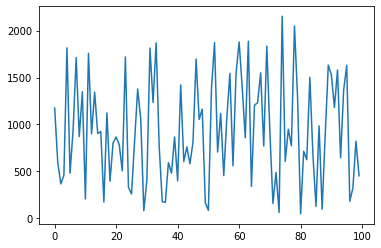

In [52]:
loss = []
for value in history4:
#     print(value)
    loss.append(value['val_loss'])
plt.plot(loss)

In [53]:
val_loss = history4[epochs-1]["val_loss"]
val_loss

451.8103942871094

## Make predictions using the trained model

In [54]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)             
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [55]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([4.3000e+01, 1.0000e+00, 2.3200e+01, 0.0000e+00, 0.0000e+00, 3.0000e+00,
        6.2504e+03])
Target: tensor([6250.4351])
Prediction: tensor([6055.9741])


In [56]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([   56.0000,     0.0000,    28.3100,     0.0000,     0.0000,     0.0000,
        11657.7188])
Target: tensor([11657.7188])
Prediction: tensor([11290.7891])


In [57]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([2.8000e+01, 0.0000e+00, 3.4770e+01, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        3.5569e+03])
Target: tensor([3556.9224])
Prediction: tensor([3443.3215])
